In [1]:
import pandas as pd
import numpy as np

In [34]:
projects = pd.read_csv('motus-projects.csv')
species = pd.read_csv('species.csv')
antenna_deployments = pd.read_csv('antenna-deployments.csv')
receiver_deployments = pd.read_csv('receiver-deployments.csv')
tag_deployments = pd.read_csv('tag-deployments.csv')

In [4]:
import sqlite3
import pandas as pd

con = sqlite3.connect('motus.db')  # подключение
cur = con.cursor()  # курсор

### Creating the table

In [406]:
def get_page(url): #скачивает страницу в soup
    
    user_agent = UserAgent().chrome
    try:
        response = session.get(url, headers={'User-Agent':user_agent})
    except Exception as err:
        with open('errors.txt', 'a') as f:
            f.write(f'{err}\t{url}\n')
    #response = session.get(url, proxies=proxy)
    soup = BeautifulSoup(response.text, 'html.parser')
    time.sleep(random.random())
    
    return soup

In [54]:
down = get_page('https://motus.org/data/downloads')

In [74]:
down_links = []

for ele in down.find_all('a'):
    if 'api-proxy' in ele['href']:
        down_links.append(ele['href'])
        
down_links

['/data/downloads/api-proxy/projects/descriptions;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv&showAll=true',
 '/data/downloads/api-proxy/tags;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv',
 '/data/downloads/api-proxy/tags/deployments;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv',
 '/data/downloads/api-proxy/receivers/deployments;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv',
 '/data/downloads/api-proxy/receivers/antennas;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv',
 '/data/downloads/api-proxy/receivers/gps;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv',
 '/data/downloads/api-proxy/fields;jsessionid=1C8A77B01E1B4321930583282356253A',
 '/data/downloads/api-proxy/species;jsessionid=1C8A77B01E1B4321930583282356253A',
 '/data/downloads/api-proxy/tags/active;jsessionid=1C8A77B01E1B4321930583282356253A']

In [73]:
url = 'https://motus.org/data/downloads/api-proxy/tags;jsessionid=1C8A77B01E1B4321930583282356253A?fmt=csv'
r = requests.get(url, allow_redirects=True)
open('ex.csv', 'wb').write(r.content)

5632052

In [89]:
names = dict(zip(down_links, [
    'motus_projects',
    'tags',
    'tag_deployments',
    'receiver_deployments',
    'antenna_deployments',
    'receivers',
    'fields',
    'species',
    'active_tags'
]))

def csv_loader(url, name, base='https://motus.org', folder='tables/'):
    url = base + url
    r = requests.get(url, allow_redirects=True)
    open(folder + name + '.csv', 'wb').write(r.content)
    
for url, name in names.items():
    csv_loader(url, name)

In [110]:
with open('tables/species.csv', 'r') as f:
    content = f.read()
    
content = content.replace('group', 'group_')

with open('tables/species.csv', 'w') as f:
    f.write(content)

### Database

In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect('tables/motus.db')  # подключение
cur = con.cursor()  # курсор

import os

def to_sqlite(file, folder='tables/', stops=[]):
    if file not in stops:
        df = pd.read_csv(os.path.join(folder, file), engine='python')
        df.to_sql(file, con, if_exists='replace', index=False)

In [22]:
for file in os.listdir('tables/'):
    if file.endswith('.csv'):
        to_sqlite(file)

### Maps 

In [299]:
import geopandas
from shapely.ops import unary_union

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
continents = world.groupby('continent')['geometry'].apply(unary_union).reset_index()
continents

,continent,geometry
0,Africa,"MULTIPOLYGON (((-11.439 6.786, -11.708 6.860, ..."
1,Antarctica,"MULTIPOLYGON (((-61.139 -79.981, -60.610 -79.6..."
2,Asia,"MULTIPOLYGON (((48.679 14.003, 48.239 13.948, ..."
3,Europe,"MULTIPOLYGON (((-53.555 2.335, -53.779 2.377, ..."
4,North America,"MULTIPOLYGON (((-155.222 19.240, -155.542 19.0..."
5,Oceania,"MULTIPOLYGON (((147.914 -43.212, 147.565 -42.9..."
6,Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5..."
7,South America,"MULTIPOLYGON (((-68.640 -55.580, -69.232 -55.4..."


In [305]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point([30, -10])
continents.loc[continents['geometry'].contains(point)]

,continent,geometry
0,Africa,"MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6..."


In [284]:
world.loc[world['geometry'].contains(point)]['continent']

159    Antarctica
Name: continent, dtype: object

In [20]:
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
continents = world.groupby('continent')['geometry'].apply(unary_union).reset_index()

def continent(gps):
    point = Point(reversed(gps))
    if continents.loc[continents['geometry'].contains(point)].empty:
        return ''
    else:
        return continents.loc[continents['geometry'].contains(point)]['continent'].values[0]

## CHANGES TO DATABASE EVERYONE

In [21]:
continent([43.4538, -81.1985])

'North America'

In [18]:
rd = pd.read_csv('receiver_deployments.csv')
rd['args'] = rd[['latitude', 'longitude']].values.tolist()
rd['continent'] = rd['args'].apply(continent)
#rd.drop(columns=['args'], inplace=True)
rd
#rd.groupby('continent').count()

NameError: name 'continent' is not defined

In [401]:
species.groupby('group').count()

,id,english,french,scientific,code,sort
group,,,,,,
BATS,45,45,9,45,0,45
BEETLES,3806,3802,0,3806,0,3806
BIRDS,10825,10825,10825,10825,0,10825
BUTTERFL,165,165,165,165,0,165
HYMENOPTERA,288,1,0,288,0,288
MAMMALS,4679,2914,7,4679,0,4679
MOTHS,2348,850,0,2348,0,2348
ODONATA,170,170,0,170,0,170
ORTHOPTERA,33,32,0,33,0,33


In [56]:
sp = pd.read_csv('species.csv')
sp.rename(columns={"group": "group_"}, inplace=True)
sp['group__']

0              BIRDS
1              BIRDS
2              BIRDS
3              BIRDS
4              BIRDS
            ...     
22375    HYMENOPTERA
22376    HYMENOPTERA
22377    HYMENOPTERA
22378    HYMENOPTERA
22379    HYMENOPTERA
Name: group__, Length: 22380, dtype: object

In [57]:
sp['group__'] = sp['group__'].map({"BATS": 'Mammals',
    "MAMMALS": 'Mammals',
    "BEETLES": 'Insects',
    "BUTTERFL": 'Insects',
    "HYMENOPTERA": 'Insects',
    "MOTHS": 'Insects',
    "ODONATA": 'Insects',
    "ORTHOPTERA": 'Insects',
    "BIRDS": 'Birds or reptiles',
    "REPTILES": 'Birds or reptiles'})
sp.to_sql(name='species', con=con, if_exists='replace')

# actual data analysis

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.option("header",True).csv("receivers.csv")

In [161]:
df.createOrReplaceTempView("receivers")

query = '''SELECT MAX(gpsLat)-MIN(gpsLat) AS dLat, MAX(gpsLon)-MIN(gpsLon) AS dLon, MAX(ts)-MIN(ts) AS dTime,
        recvDeployID
        FROM receivers
        GROUP BY recvDeployID
        ORDER BY recvDeployID'''

sqlDF = spark.sql(query)

In [162]:
data = sqlDF.toPandas()
data

,dLat,dLon,dTime,recvDeployID
0,0.5350,-0.0336,2219863.0,1031
1,0.0026,-0.0138,273600.0,1035
2,0.0007,-0.0007,4314578.0,1040
3,0.0000,-0.0001,6916342.0,1041
4,0.1712,-0.0165,12289453.0,1043
...,...,...,...,...
1606,0.0004,-0.0004,7449651.0,935
1607,0.0192,-0.1428,3894625.0,939
1608,0.0002,-0.0006,1210451.7,959
1609,0.0002,-0.0003,5174700.0,981


In [166]:
import pandas as pd
import sqlite3

con = sqlite3.connect("motus.db")
tab = pd.read_sql_query('''SELECT english, group__, speciesID, 
                receiver_deployments.deploymentStatus, receiver_deployments.recvProjectID, continent,
                receiver_deployments.recvDeployID
                
                FROM tag_deployments
JOIN receiver_deployments ON receiver_deployments.recvProjectID = tag_deployments.tagProjectID
JOIN species ON tag_deployments.speciesID = species.id
''', con)
tab

,english,group__,speciesID,deploymentStatus,recvProjectID,continent,recvDeployID
0,Canada Goose,Birds or reptiles,230,active,276,North America,5729
1,Canada Goose,Birds or reptiles,230,active,276,North America,5730
2,Canada Goose,Birds or reptiles,230,active,276,North America,5731
3,Canada Goose,Birds or reptiles,230,active,276,North America,5732
4,Canada Goose,Birds or reptiles,230,active,276,North America,5752
...,...,...,...,...,...,...,...
829441,None,Insects,1000093,terminated,113,Europe,8015
829442,None,Insects,1000093,active,113,Europe,8036
829443,None,Insects,1000093,active,113,,8081
829444,None,Insects,1000093,active,113,,8181


In [167]:
data['recvDeployID'] = data['recvDeployID'].astype(int)

df = tab.set_index('recvDeployID').join(data.set_index('recvDeployID'))
df.dropna(subset=['dLat', 'dLon', 'dTime'], inplace=True)
df

,english,group__,speciesID,deploymentStatus,recvProjectID,continent,dLat,dLon,dTime
recvDeployID,,,,,,,,,
629,Piping Plover,Birds or reptiles,4190,terminated,1,North America,0.941900,-0.5413,10571666.0
629,Common Tern,Birds or reptiles,5570,terminated,1,North America,0.941900,-0.5413,10571666.0
630,Piping Plover,Birds or reptiles,4190,terminated,1,North America,0.001000,-0.0007,10630623.0
630,Common Tern,Birds or reptiles,5570,terminated,1,North America,0.001000,-0.0007,10630623.0
631,Piping Plover,Birds or reptiles,4190,terminated,1,North America,0.000300,-0.0003,3003021.0
...,...,...,...,...,...,...,...,...,...
8449,Peregrine Falcon,Birds or reptiles,45581,terminated,48,North America,0.000088,-0.0001,8103.0
8449,Peregrine Falcon,Birds or reptiles,45581,terminated,48,North America,0.000088,-0.0001,8103.0
8449,Peregrine Falcon,Birds or reptiles,45581,terminated,48,North America,0.000088,-0.0001,8103.0


In [168]:
'''collide = ['Snow Bunting', 'Red-eyed Vireo',
       'Common Green Darner', 'Northern Long-eared Bat',
       'Northern Saw-whet Owl', 'Loggerhead Shrike', 'American Woodcock',
       'Saltmarsh Sparrow', 'Northern Waterthrush', 'Merlin',
       'Least Sandpiper', 'Monarch', 'Eastern Red Bat', 'Bicknell\'s Thrush',
       'Whimbrel', 'Leach\'s Storm-Petrel', 'White-throated Sparrow',
       'Yellow-billed Cuckoo', 'Red Phalarope', 'Yellow-rumped Warbler',
       'Great Black-backed Gull', 'Rusty Blackbird', 'Black-bellied Plover',
       'Eastern Small-footed Bat', 'Red-necked Phalarope',
       'Northern Long-eared Myotis', 'Pine Siskin', 'Eastern Pipistrelle',
       'Herring Gull', 'Big Brown Bat', 'Dunlin']

def sorter(s):
    if s in collide: 
        return 'Other'
    else:
        return s
    
df['english'] = df['english'].apply(sorter)'''
df.drop(columns=['speciesID', 'recvProjectID', 'deploymentStatus'], inplace=True)
df = df.drop_duplicates()

In [169]:
df['dDist'] = (df['dLat']**2 + df['dLon']**2)**0.5
df['speed'] = df['dDist'] / df['dTime']
df

<ipython-input-169-5a61d19a8e51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dDist'] = (df['dLat']**2 + df['dLon']**2)**0.5
<ipython-input-169-5a61d19a8e51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['dDist'] / df['dTime']


,english,group__,continent,dLat,dLon,dTime,dDist,speed
recvDeployID,,,,,,,,
629,Piping Plover,Birds or reptiles,North America,0.941900,-0.5413,10571666.0,1.086361,1.027616e-07
629,Common Tern,Birds or reptiles,North America,0.941900,-0.5413,10571666.0,1.086361,1.027616e-07
630,Piping Plover,Birds or reptiles,North America,0.001000,-0.0007,10630623.0,0.001221,1.148245e-10
630,Common Tern,Birds or reptiles,North America,0.001000,-0.0007,10630623.0,0.001221,1.148245e-10
631,Piping Plover,Birds or reptiles,North America,0.000300,-0.0003,3003021.0,0.000424,1.412791e-10
...,...,...,...,...,...,...,...,...
8449,Northern Saw-whet Owl,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08
8449,Wood Thrush,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08
8449,Golden-winged Warbler,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08


# razvedka

In [170]:
df.head(10)

,english,group__,continent,dLat,dLon,dTime,dDist,speed
recvDeployID,,,,,,,,
629,Piping Plover,Birds or reptiles,North America,0.9419,-0.5413,10571666.0,1.086361,1.027616e-07
629,Common Tern,Birds or reptiles,North America,0.9419,-0.5413,10571666.0,1.086361,1.027616e-07
630,Piping Plover,Birds or reptiles,North America,0.0010,-0.0007,10630623.0,0.001221,1.148245e-10
630,Common Tern,Birds or reptiles,North America,0.0010,-0.0007,10630623.0,0.001221,1.148245e-10
631,Piping Plover,Birds or reptiles,North America,0.0003,-0.0003,3003021.0,0.000424,1.412791e-10
631,Common Tern,Birds or reptiles,North America,0.0003,-0.0003,3003021.0,0.000424,1.412791e-10
632,Piping Plover,Birds or reptiles,North America,0.0018,-0.0005,74363.0,0.001868,2.512209e-08
632,Common Tern,Birds or reptiles,North America,0.0018,-0.0005,74363.0,0.001868,2.512209e-08
633,Piping Plover,Birds or reptiles,North America,0.0001,-0.0001,5844131.0,0.000141,2.419887e-11


In [130]:
df.describe()

,dLat,dLon,dTime,dDist,speed
count,1206.000000,1206.000000,1.206000e+03,1206.000000,1.191000e+03
mean,1.184235,0.605630,2.113231e+07,1.939280,3.782166e-07
std,27.792470,31.294721,2.621910e+07,41.830463,6.447138e-06
min,-0.466600,-81.309800,0.000000e+00,0.000000,0.000000e+00
25%,0.000200,-0.002100,4.073990e+06,0.000316,2.712475e-11
50%,0.000414,-0.000400,1.258061e+07,0.000688,9.774289e-11
75%,0.002392,-0.000176,2.799854e+07,0.004165,5.225565e-10
max,957.692800,1069.063600,2.222972e+08,1435.295259,1.925646e-04


# one hot

In [133]:
df_ohe = pd.get_dummies(df[df.columns[1:]])
df_ohe

,dLat,dLon,dTime,dDist,speed,group___Birds or reptiles,group___Insects,group___Mammals
recvDeployID,,,,,,,,
629,0.941900,-0.541300,10571666.0,1.086361,1.027616e-07,1,0,0
630,0.001000,-0.000700,10630623.0,0.001221,1.148245e-10,1,0,0
631,0.000300,-0.000300,3003021.0,0.000424,1.412791e-10,1,0,0
632,0.001800,-0.000500,74363.0,0.001868,2.512209e-08,1,0,0
633,0.000100,-0.000100,5844131.0,0.000141,2.419887e-11,1,0,0
...,...,...,...,...,...,...,...,...
8446,0.000127,-0.000200,410676.0,0.000237,5.768918e-10,1,0,0
8447,0.000102,-0.000145,329526.0,0.000177,5.379917e-10,1,0,0
8455,0.000100,-0.000100,90301.0,0.000141,1.566111e-09,1,0,0


## group by group__

In [180]:
gr_means = df.groupby('group__')[['dTime', 'dDist', 'speed']].mean()
gr_means['speed'] = gr_means['speed'] * 111 * 3600
gr_means

,dTime,dDist,speed
group__,,,
Birds or reptiles,2.719495e+07,0.573595,0.141853
Insects,3.714427e+07,0.828598,0.004279
Mammals,2.419828e+07,0.632228,0.050228


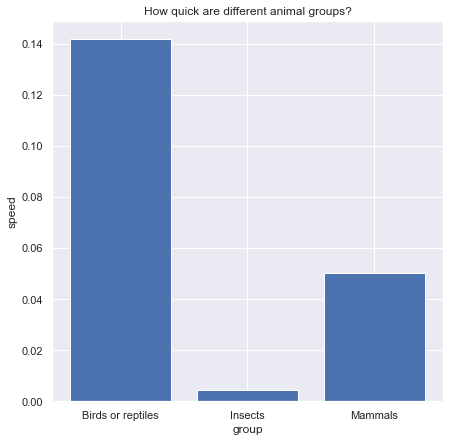

In [189]:
plt.bar(gr_means.index, gr_means['speed'])
plt.title('How quick are different animal groups?')
plt.xlabel('group')
plt.ylabel('speed')
plt.savefig('static/gr_means.png')

## group by continent

In [185]:
cont_means = df.groupby('continent')[['dTime', 'dDist', 'speed']].mean()
cont_means['speed'] = cont_means['speed'] * 111 * 3600
cont_means

,dTime,dDist,speed
continent,,,
,3.125377e+07,1.431402,0.034464
Europe,3.315819e+07,0.012304,0.003174
North America,2.362726e+07,0.597753,0.182959
South America,2.563076e+07,0.038756,0.000696


Text(0, 0.5, 'speed')

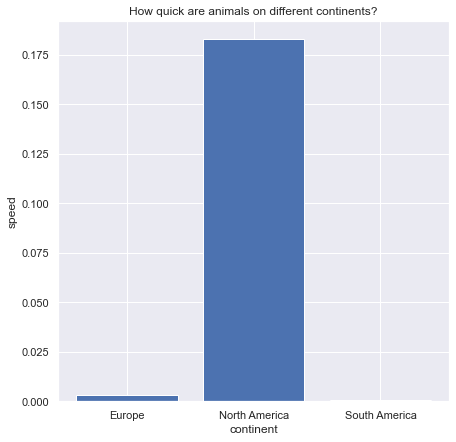

In [188]:
plt.bar(cont_means.index[1:], cont_means['speed'][1:])
plt.title('How quick are animals on different continents?')
plt.xlabel('continent')
plt.ylabel('speed')

# model training

In [107]:
df_ohe.dropna(inplace=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(df_ohe)
df_ohe

,dLat,dLon,dTime,group___Birds or reptiles,group___Insects,group___Mammals,dDist,speed
recvDeployID,,,,,,,,
629,0.941900,-0.541300,10571666.0,1,0,0,1.086361,1.027616e-07
630,0.001000,-0.000700,10630623.0,1,0,0,0.001221,1.148245e-10
631,0.000300,-0.000300,3003021.0,1,0,0,0.000424,1.412791e-10
632,0.001800,-0.000500,74363.0,1,0,0,0.001868,2.512209e-08
633,0.000100,-0.000100,5844131.0,1,0,0,0.000141,2.419887e-11
...,...,...,...,...,...,...,...,...
8446,0.000127,-0.000200,410676.0,1,0,0,0.000237,5.768918e-10
8447,0.000102,-0.000145,329526.0,1,0,0,0.000177,5.379917e-10
8455,0.000100,-0.000100,90301.0,1,0,0,0.000141,1.566111e-09


In [109]:
df_ohe.mean()

dLat                         1.199149e+00
dLon                         6.132571e-01
dTime                        2.139846e+07
group___Birds or reptiles    9.109992e-01
group___Insects              1.343409e-02
group___Mammals              7.556675e-02
dDist                        1.963704e+00
speed                        3.782166e-07
dtype: float64

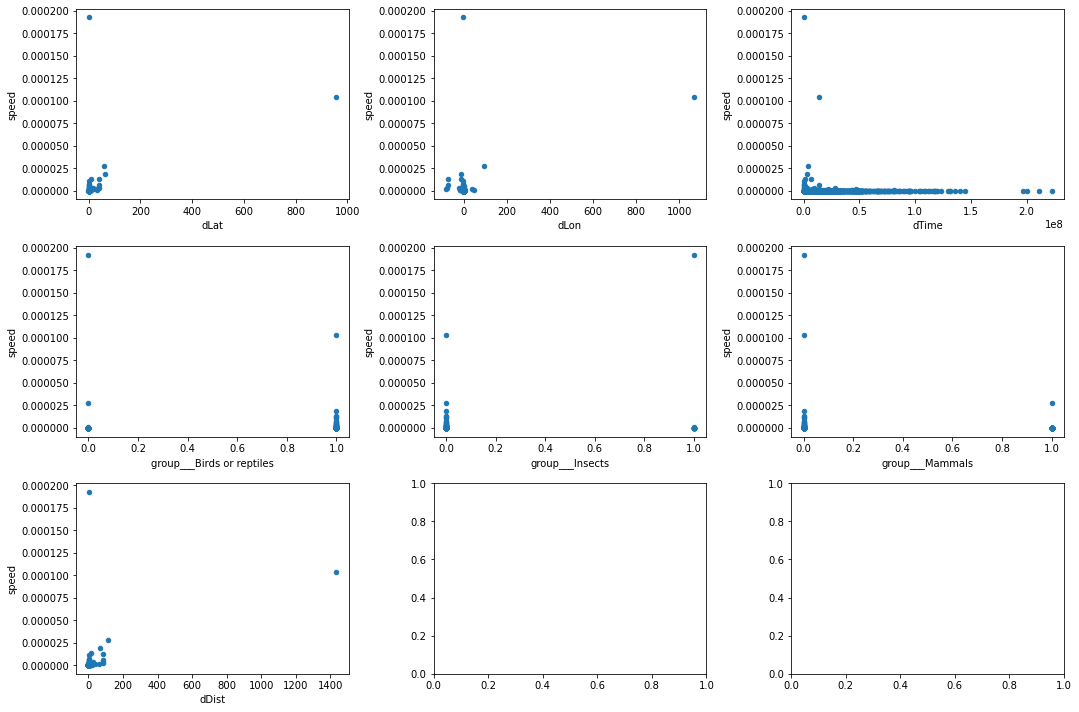

In [110]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(df_ohe.columns[:-1]):
    df_ohe.plot(feature, "speed", subplots=True, kind="scatter", ax=axes[idx // 3, idx % 3])
plt.tight_layout()

/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarni

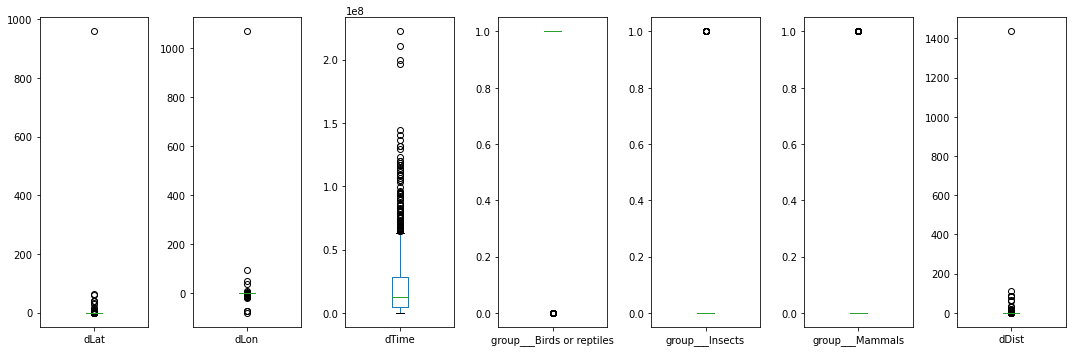

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))
for idx, feature in enumerate(df_ohe.columns):
    df_ohe.plot(feature, subplots=True, kind="box", ax=axes[idx // 3, idx % 3])
plt.tight_layout()

<AxesSubplot:>

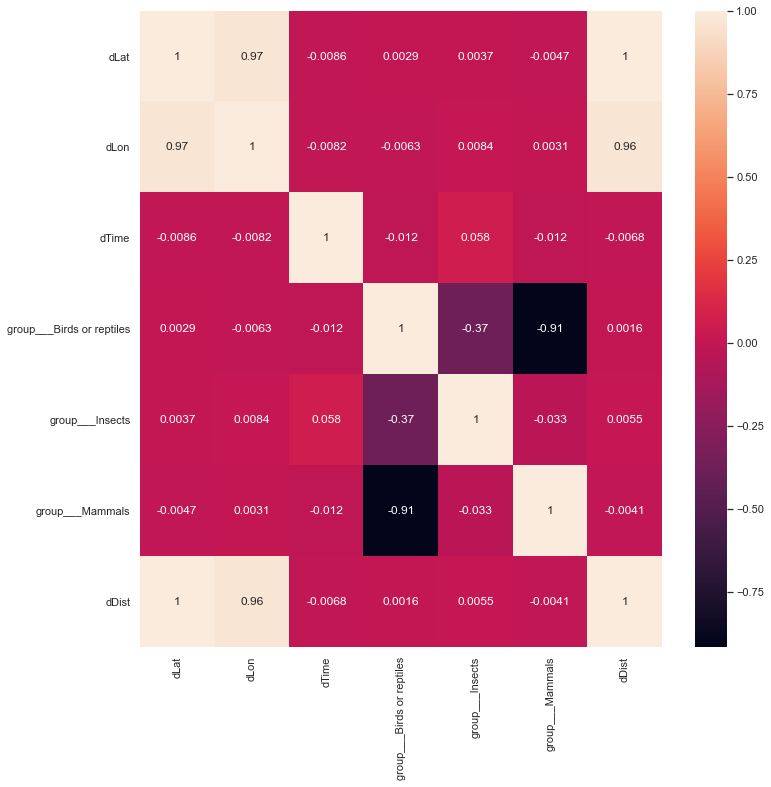

In [113]:
import seaborn as sns

corr = df_ohe[df_ohe.columns[:-1]].corr()
sns.set(rc={'figure.figsize':(11.7,11.7)})
sns.heatmap(corr, annot=True)

In [121]:
X = df_ohe[df_ohe.columns[:-1]]
y = df_ohe['speed']
X

,dLat,dLon,dTime,group___Birds or reptiles,group___Insects,group___Mammals,dDist
recvDeployID,,,,,,,
629,0.941900,-0.541300,10571666.0,1,0,0,1.086361
630,0.001000,-0.000700,10630623.0,1,0,0,0.001221
631,0.000300,-0.000300,3003021.0,1,0,0,0.000424
632,0.001800,-0.000500,74363.0,1,0,0,0.001868
633,0.000100,-0.000100,5844131.0,1,0,0,0.000141
...,...,...,...,...,...,...,...
8446,0.000127,-0.000200,410676.0,1,0,0,0.000237
8447,0.000102,-0.000145,329526.0,1,0,0,0.000177
8455,0.000100,-0.000100,90301.0,1,0,0,0.000141


dLat	2.236512626395083e-07
dLon	-5.9579159874013674e-08
dTime	-1.0812840861146259e-14
group___Birds or reptiles	-4.89185676456322e-06
group___Insects	9.821305108015719e-06
group___Mammals	-4.9294483434525e-06
dDist	-3.303971919457672e-08


/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

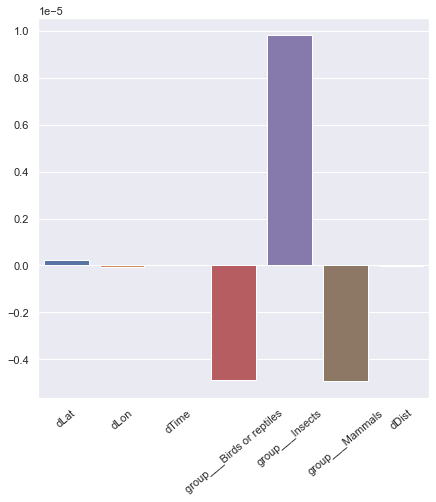

In [123]:
# pre Lasso

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=1)

model = LinearRegression().fit(X_tr, y_tr)

for ele in zip(df_ohe.columns[:-1], model.coef_):
    print(ele[0], ele[1], sep='\t')
    
sns.set(rc={'figure.figsize':(7, 7)})
g = sns.barplot(df_ohe.columns[:-1], model.coef_)
g.set_xticklabels(g.get_xticklabels(), rotation=40)
g

dLat	0.0
dLon	0.0
dTime	-8.762820817801185e-15
group___Birds or reptiles	-0.0
group___Insects	0.0
group___Mammals	-0.0
dDist	0.0


/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

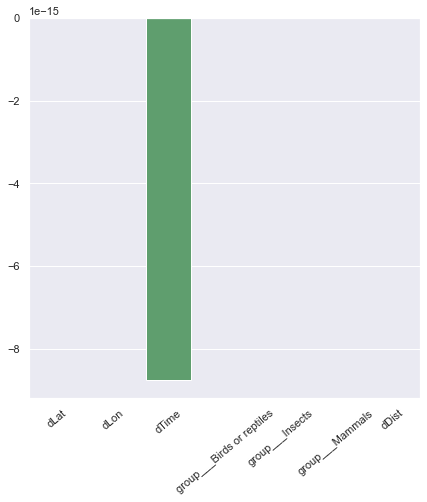

In [124]:
# post Lasso

from sklearn.linear_model import Lasso

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=1)

model = Lasso().fit(X_tr, y_tr)

for ele in zip(df_ohe.columns[:-1], model.coef_):
    print(ele[0], ele[1], sep='\t')
    
sns.set(rc={'figure.figsize':(7, 7)})
g = sns.barplot(df_ohe.columns[:-1], model.coef_)
g.set_xticklabels(g.get_xticklabels(), rotation=40)
g

dLat	2.1906377768527887e-07
dLon	-5.914423559218807e-08
dTime	-1.0706456166717487e-14
group___Birds or reptiles	-4.673569727968301e-06
group___Insects	9.313306472220478e-06
group___Mammals	-4.639736744258636e-06
dDist	-3.028685683573802e-08


/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.6879e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

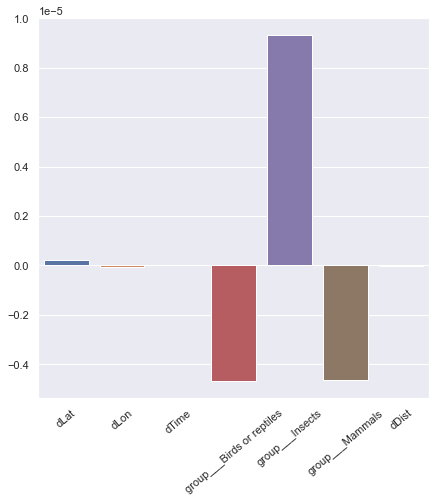

In [125]:
# post Ridge

from sklearn.linear_model import Ridge

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=1)

model = Ridge().fit(X_tr, y_tr)

for ele in zip(df_ohe.columns[:-1], model.coef_):
    print(ele[0], ele[1], sep='\t')
    
sns.set(rc={'figure.figsize':(7, 7)})
g = sns.barplot(df_ohe.columns[:-1], model.coef_)
g.set_xticklabels(g.get_xticklabels(), rotation=40)
g

In [187]:
# Factor analysis? do we need it?

from sklearn.decomposition import FactorAnalysis

transformer = FactorAnalysis(n_components=4, random_state=0)
X_transformed = transformer.fit_transform(X)
#X_transformed.shape
X = X_transformed

In [191]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression().fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = mean_absolute_error(y_train, pred_train)
acc_test = mean_absolute_error(y_test, pred_test)
print('Train MAE: ', acc_train)
print('Test MAE: ', acc_test)
print('test mean:', np.mean(y_test))

Train MAE:  0.003985551246740003
Test MAE:  0.002709901122066088
test mean: 0.0011980085578273836


In [182]:
model.coef_

array([ 0.00179036,  0.00207412,  0.00403647,  0.01319569, -0.00023962,
       -0.00050657, -0.00014058])

In [171]:
weights_data = {"веса":model.coef_,
                "признаки": df_ohe.columns[2:-2]}
weights = pd.DataFrame(weights_data)
weights.sort_values("веса")

,веса,признаки
0,-6.361308e-03,dTime
28,2.800175e+10,group__BATS
31,2.800175e+10,group__MAMMALS
29,2.800175e+10,group__BIRDS
32,2.800175e+10,group__ODONATA
30,2.800175e+10,group__BUTTERFL
22,5.149742e+10,english_Savannah Sparrow
3,5.149742e+10,english_Bank Swallow
19,5.149742e+10,english_Red Knot
27,5.149742e+10,english_Wood Thrush


In [190]:
df.sort_values('dDist', ascending=False)

,english,group__,continent,dLat,dLon,dTime,dDist,speed
recvDeployID,,,,,,,,
5401,Dunlin,Birds or reptiles,North America,58.7818,93.7888,4.005245e+06,110.687122,0.000028
5401,Short-billed Dowitcher,Birds or reptiles,North America,58.7818,93.7888,4.005245e+06,110.687122,0.000028
5401,Stilt Sandpiper,Birds or reptiles,North America,58.7818,93.7888,4.005245e+06,110.687122,0.000028
5401,Semipalmated Plover,Birds or reptiles,North America,58.7818,93.7888,4.005245e+06,110.687122,0.000028
5401,Lesser Yellowlegs,Birds or reptiles,North America,58.7818,93.7888,4.005245e+06,110.687122,0.000028
...,...,...,...,...,...,...,...,...
2425,Northern Long-eared Bat,Mammals,,0.0000,0.0000,1.197626e+06,0.000000,0.000000
2425,Little Brown Bat,Mammals,,0.0000,0.0000,1.197626e+06,0.000000,0.000000
2425,Hoary Bat,Mammals,,0.0000,0.0000,1.197626e+06,0.000000,0.000000


In [191]:
110.687122 * 111

12286.270542

# Classifier

In [193]:
df.dropna(inplace=True)
df

<ipython-input-193-b5dde2205341>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,english,group__,continent,dLat,dLon,dTime,dDist,speed
recvDeployID,,,,,,,,
629,Piping Plover,Birds or reptiles,North America,0.941900,-0.5413,10571666.0,1.086361,1.027616e-07
629,Common Tern,Birds or reptiles,North America,0.941900,-0.5413,10571666.0,1.086361,1.027616e-07
630,Piping Plover,Birds or reptiles,North America,0.001000,-0.0007,10630623.0,0.001221,1.148245e-10
630,Common Tern,Birds or reptiles,North America,0.001000,-0.0007,10630623.0,0.001221,1.148245e-10
631,Piping Plover,Birds or reptiles,North America,0.000300,-0.0003,3003021.0,0.000424,1.412791e-10
...,...,...,...,...,...,...,...,...
8449,Northern Saw-whet Owl,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08
8449,Wood Thrush,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08
8449,Golden-winged Warbler,Birds or reptiles,North America,0.000088,-0.0001,8103.0,0.000133,1.643917e-08


In [202]:
clf_data = df[df.columns[2:]]
X = pd.get_dummies(clf_data).columns
y = df['group__']
X = scaler.fit_transform(X)
X

array([[ 0.18595036, -0.1403724 , -0.52539174, ..., -0.49541553,
         0.77179061, -0.1615292 ],
       [ 0.18595036, -0.1403724 , -0.52539174, ..., -0.49541553,
         0.77179061, -0.1615292 ],
       [-0.09881697, -0.03082457, -0.52350767, ..., -0.49541553,
         0.77179061, -0.1615292 ],
       ...,
       [-0.09909299, -0.03070298, -0.86296821, ..., -0.49541553,
         0.77179061, -0.1615292 ],
       [-0.09909299, -0.03070298, -0.86296821, ..., -0.49541553,
         0.77179061, -0.1615292 ],
       [-0.09909299, -0.03070298, -0.86296821, ..., -0.49541553,
         0.77179061, -0.1615292 ]])

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=1)

model = LinearSVC().fit(X_tr, y_tr)

print(model.coef_)
print(model.classes_)

[[ 0.06000483  0.01261036  0.076227   -0.09020791  0.00977903 -0.03875759
  -0.19189533  0.15480294  0.09736564]
 [ 0.01657104  0.071957    0.00247639 -0.08249426 -0.05638458  0.00285197
   0.0195477  -0.01621595 -0.00605399]
 [-0.045981   -0.02088587 -0.07896112  0.07057263 -0.00749341  0.03645028
   0.17250183 -0.13878827 -0.09232101]]
['Birds or reptiles' 'Insects' 'Mammals']


/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


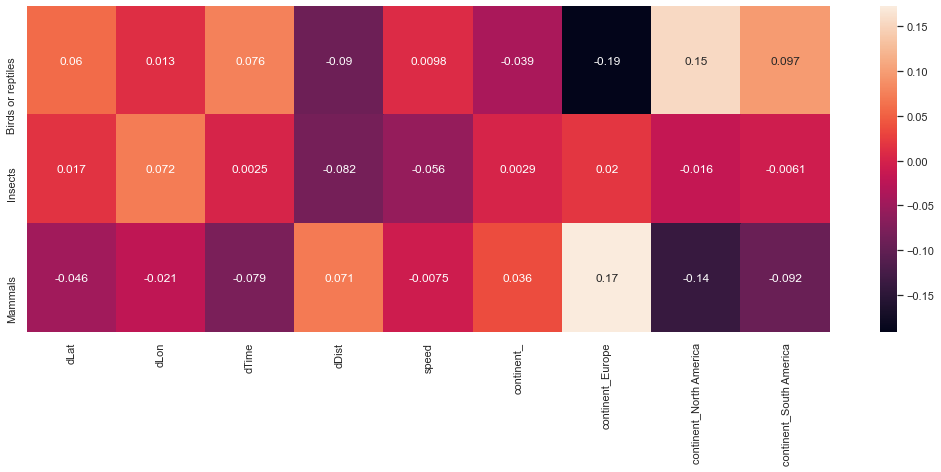

In [217]:
vecs = pd.DataFrame(model.coef_, index=model.classes_, columns=pd.get_dummies(clf_data).columns)

sns.set(rc={'figure.figsize':(18,6)})
g = sns.heatmap(vecs, annot=True)
fig = g.get_figure()
fig.savefig('static/heatmap.png')


'''A linear classifier has been created and fed the Motus data. It can now predict the group of an animal (mammal, bird/reptile, insect) with an accuracy score of 0.77.

The input variables and the weights the model has assigned are presented on the heatmap below. We can see, for instance, that there are more mammals tracked in Europe than in North America or that birds have slightly longer migration routes.'''

In [205]:
preds = model.predict(X_te)

from sklearn.metrics import accuracy_score

accuracy_score(y_te, preds)

0.7686874632136551

In [ ]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=SparkConf())

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.option("header",True).csv("receivers.csv")

In [7]:
query = '''ALTER TABLE * ROW_FORMAT=COMPRESSED;'''

con = sqlite3.connect('motus.db')  # подключение
cur = con.cursor()  # курсор

cur.execute(query)

OperationalError: near "*": syntax error

In [ ]:
df.createOrReplaceTempView("receivers")

query = '''SELECT FROM receivers
LIMIT 1000000;'''

rec_small = spark.sql(query)
rec_small.to_sql('receivers', con, if_exists='replace', index=False)

In [3]:
import pandas as pd

rec_small = pd.read_csv('receivers.csv')

In [5]:
rec_small[:1_000_000].to_sql('receivers', con, if_exists='replace', index=False)

In [6]:
con.close()